2025-05-15 08:49:53,554 - INFO - Market data for forward curve loaded successfully from /Users/oscarxue/Downloads/Matlab_df.xlsx.
2025-05-15 08:49:53,555 - INFO - Forward price interpolator created.
2025-05-15 08:49:53,556 - INFO - Initializing Total Implied Variance surface for Dupire calculation...
2025-05-15 08:49:53,557 - INFO - Attempting to load model volatility grid from: /Users/oscarxue/Documents/MATLAB/model_vs_market_vols.csv
2025-05-15 08:49:53,560 - INFO - Loaded /Users/oscarxue/Documents/MATLAB/model_vs_market_vols.csv successfully. Shape: (1638, 5)
2025-05-15 08:49:53,561 - INFO - Columns: ['Maturity', 'Strike', 'LogMoneyness', 'MarketVol', 'ModelVol']
2025-05-15 08:49:53,562 - INFO - First 5 rows of loaded data:
   Maturity  Strike  LogMoneyness  MarketVol  ModelVol
0  0.021918    5460     -0.057967   0.296583  0.385665
1  0.021918    5470     -0.056137   0.294824  0.381333
2  0.021918    5475     -0.055224   0.293652  0.379154
3  0.021918    5480     -0.054311   0.29306

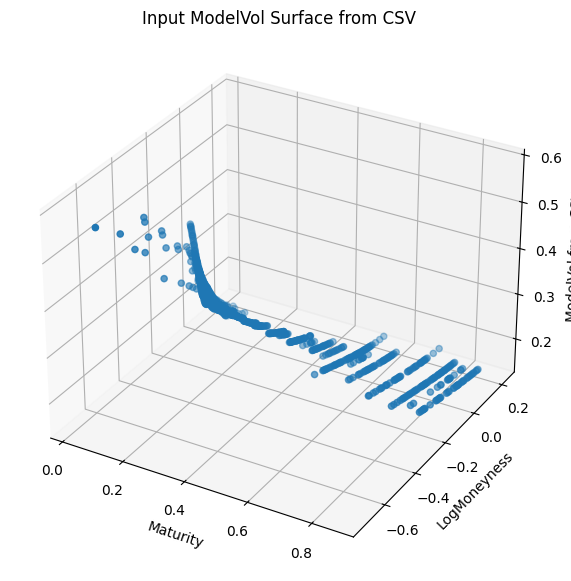

2025-05-15 08:49:53,648 - INFO - Displayed plot of input ModelVol surface from CSV.
2025-05-15 08:49:53,649 - INFO - Sample TotalVariance stats: Min=0.0009, Max=0.0331, Mean=0.0070
2025-05-15 08:49:53,649 - INFO - Data shape after NaN drop: (1638, 6)
2025-05-15 08:49:53,650 - INFO - Unique Maturities count: 40 (Min: 0.0219, Max: 0.8658)
2025-05-15 08:49:53,650 - INFO - Unique LogMoneyness count: 1638 (Min: -0.7279, Max: 0.2222)
2025-05-15 08:49:53,658 - INFO - Pivot table shape: (40, 1638)
/var/folders/9_/mqsyyrcx6n93sgb32yjd96140000gn/T/ipykernel_19997/1278765789.py:139: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  w_grid_df = w_grid_df.fillna(method='bfill').fillna(method='ffill')
2025-05-15 08:49:53,709 - INFO - Total Implied Variance surface interpolator created (kx=3, ky=3). Knots: T(40), k(1638)
2025-05-15 08:49:53,711 - INFO - Initializing Total Implied Variance surface for Dupire calcul

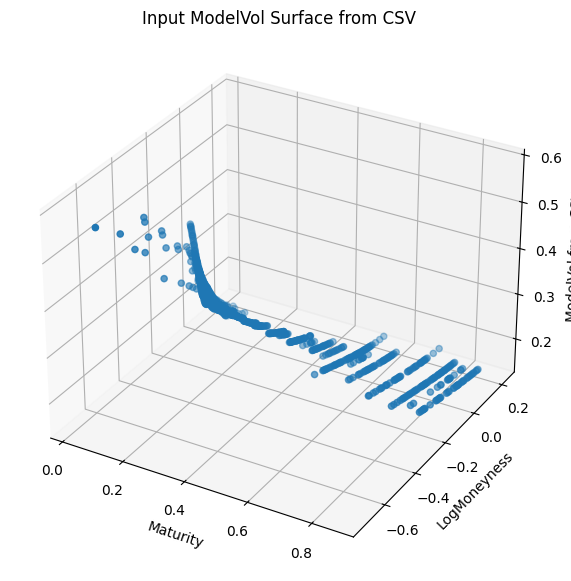

2025-05-15 08:49:53,794 - INFO - Displayed plot of input ModelVol surface from CSV.
2025-05-15 08:49:53,795 - INFO - Sample TotalVariance stats: Min=0.0009, Max=0.0331, Mean=0.0070
2025-05-15 08:49:53,796 - INFO - Data shape after NaN drop: (1638, 6)
2025-05-15 08:49:53,796 - INFO - Unique Maturities count: 40 (Min: 0.0219, Max: 0.8658)
2025-05-15 08:49:53,796 - INFO - Unique LogMoneyness count: 1638 (Min: -0.7279, Max: 0.2222)
2025-05-15 08:49:53,799 - INFO - Pivot table shape: (40, 1638)
/var/folders/9_/mqsyyrcx6n93sgb32yjd96140000gn/T/ipykernel_19997/1278765789.py:139: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  w_grid_df = w_grid_df.fillna(method='bfill').fillna(method='ffill')
2025-05-15 08:49:53,835 - INFO - Total Implied Variance surface interpolator created (kx=3, ky=3). Knots: T(40), k(1638)
2025-05-15 08:49:53,835 - INFO - Total Variance surface interpolator initialized.
2025-05-15 0

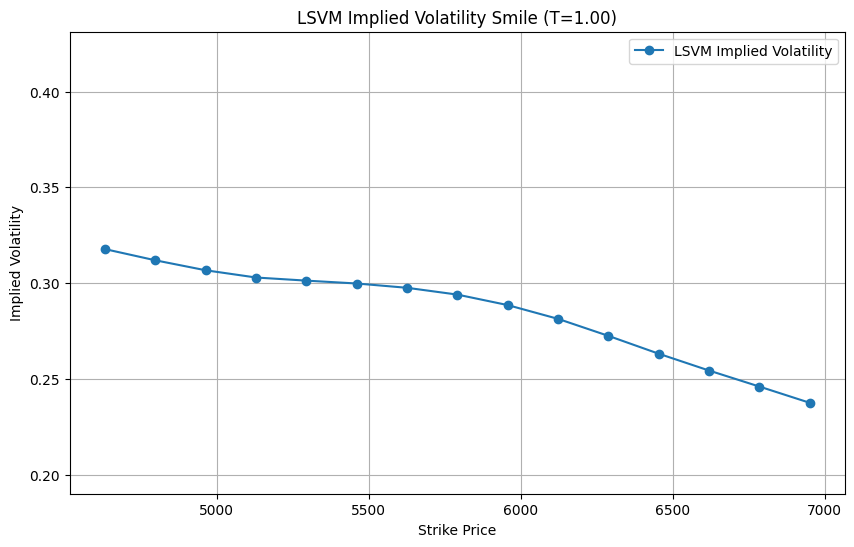

In [40]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import RectBivariateSpline, interp1d # For surface and 1D interpolation
from scipy.optimize import brentq # For implied volatility calculation
import logging # For better logging
# Attempt to import matplotlib for diagnostics
try:
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D # For 3D plotting
    MATPLOTLIB_AVAILABLE = True
except ImportError:
    MATPLOTLIB_AVAILABLE = False
    logging.info("Matplotlib not installed. Diagnostic plots will be skipped.")


# --- Configuration and Parameters ---
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Simulation parameters
N = 10000  # Number of particles
M = 250    # Number of time steps
T = 1.0    # Time to maturity
L_BINS = 50 # Number of bins
RHO = -0.7   # Correlation

# Financial Parameters
S0 = 5792.0
V0 = 0.1024  # Initial variance
R_RATE = 0.01 # Risk-free rate
Q_DIVIDEND = 0.0 # Dividend yield

# Parameters for the stochastic volatility process v_t (CIR process example)
KAPPA = 1.5768 # Mean reversion speed for variance
THETA_V = 0.0484 # Long-term mean of variance
XI = 0.5751    # Volatility of variance

# --- File Paths ---
MARKET_DATA_FOR_FORWARD_CURVE_PATH = '/Users/oscarxue/Downloads/Matlab_df.xlsx' # For S0, F(T)
MODEL_VOLS_FOR_DUPURE_PATH = '/Users/oscarxue/Documents/MATLAB/model_vs_market_vols.csv'

# --- Global Variables for Interpolators and Spline Orders ---
FORWARD_PRICE_INTERPOLATOR = None
TOTAL_VARIANCE_INTERPOLATOR = None
GLOBAL_KX_SPLINE_ORDER = 3 # Default, will be updated
GLOBAL_KY_SPLINE_ORDER = 3 # Default, will be updated
USING_PLACEHOLDER_SURFACE = False # Flag to check if placeholder is active


# --- Load Data ---
try:
    market_data_df_fwd = pd.read_excel(
        MARKET_DATA_FOR_FORWARD_CURVE_PATH,
        sheet_name='Sheet1', 
        engine='openpyxl'
    )
    logging.info(f"Market data for forward curve loaded successfully from {MARKET_DATA_FOR_FORWARD_CURVE_PATH}.")
    fwd_curve_data = market_data_df_fwd[['maturity', 'forward']].drop_duplicates(subset=['maturity']).sort_values(by='maturity')
    if len(fwd_curve_data['maturity']) < 2:
        logging.warning("Not enough data points to interpolate forward curve. Using S0*exp((R_RATE-Q_DIVIDEND)*t).")
        FORWARD_PRICE_INTERPOLATOR = lambda t_val: S0 * np.exp((R_RATE - Q_DIVIDEND) * t_val)
    else:
        FORWARD_PRICE_INTERPOLATOR = interp1d(fwd_curve_data['maturity'], fwd_curve_data['forward'], kind='linear', fill_value="extrapolate")
        logging.info("Forward price interpolator created.")
except FileNotFoundError:
    logging.error(f"Market data file for forward curve not found at {MARKET_DATA_FOR_FORWARD_CURVE_PATH}.")
    logging.warning("Using S0*exp((R_RATE-Q_DIVIDEND)*t) for forward prices as a fallback.")
    FORWARD_PRICE_INTERPOLATOR = lambda t_val: S0 * np.exp((R_RATE - Q_DIVIDEND) * t_val)
except Exception as e:
    logging.error(f"Error loading market data for forward curve: {e}")
    logging.warning("Using S0*exp((R_RATE-Q_DIVIDEND)*t) for forward prices as a fallback.")
    FORWARD_PRICE_INTERPOLATOR = lambda t_val: S0 * np.exp((R_RATE - Q_DIVIDEND) * t_val)

# --- Dupire Local Volatility Surface ---

def initialize_dupire_surface_from_total_variance(total_variance_data_file_path):
    global TOTAL_VARIANCE_INTERPOLATOR, GLOBAL_KX_SPLINE_ORDER, GLOBAL_KY_SPLINE_ORDER, USING_PLACEHOLDER_SURFACE
    logging.info("Initializing Total Implied Variance surface for Dupire calculation...")
    USING_PLACEHOLDER_SURFACE = False 

    GLOBAL_KX_SPLINE_ORDER, GLOBAL_KY_SPLINE_ORDER = 3, 3 

    if total_variance_data_file_path:
        try:
            logging.info(f"Attempting to load model volatility grid from: {total_variance_data_file_path}")
            df_vols = pd.read_csv(total_variance_data_file_path)
            logging.info(f"Loaded {total_variance_data_file_path} successfully. Shape: {df_vols.shape}")
            logging.info(f"Columns: {df_vols.columns.tolist()}")
            logging.info(f"First 5 rows of loaded data:\n{df_vols.head()}")

            if 'ModelVol' in df_vols.columns:
                logging.info(f"Sample ModelVol stats: Min={df_vols['ModelVol'].min():.4f}, Max={df_vols['ModelVol'].max():.4f}, Mean={df_vols['ModelVol'].mean():.4f}")
                if MATPLOTLIB_AVAILABLE:
                    try:
                        fig = plt.figure(figsize=(10, 7))
                        ax = fig.add_subplot(111, projection='3d')
                        ax.scatter(df_vols['Maturity'], df_vols['LogMoneyness'], df_vols['ModelVol'])
                        ax.set_xlabel('Maturity')
                        ax.set_ylabel('LogMoneyness')
                        ax.set_zlabel('ModelVol from CSV')
                        ax.set_title('Input ModelVol Surface from CSV')
                        plt.show()
                        logging.info("Displayed plot of input ModelVol surface from CSV.")
                    except Exception as plot_e:
                        logging.warning(f"Could not plot input ModelVol surface: {plot_e}")

            else:
                logging.warning("'ModelVol' column not found. Check CSV.")


            required_cols = {'Maturity', 'LogMoneyness', 'ModelVol'}
            if not required_cols.issubset(df_vols.columns):
                raise ValueError(f"Data CSV must contain {required_cols} columns.")

            df_vols['TotalVariance'] = df_vols['ModelVol']**2 * df_vols['Maturity']
            logging.info(f"Sample TotalVariance stats: Min={df_vols['TotalVariance'].min():.4f}, Max={df_vols['TotalVariance'].max():.4f}, Mean={df_vols['TotalVariance'].mean():.4f}")
            
            df_vols.dropna(subset=['Maturity', 'LogMoneyness', 'TotalVariance'], inplace=True)
            if df_vols.empty: raise ValueError("No valid data points after NaN removal for total variance surface.")
            logging.info(f"Data shape after NaN drop: {df_vols.shape}")


            maturities_unique_input = np.sort(df_vols['Maturity'].unique())
            logmoneyness_unique_input = np.sort(df_vols['LogMoneyness'].unique())
            logging.info(f"Unique Maturities count: {len(maturities_unique_input)} (Min: {maturities_unique_input.min():.4f}, Max: {maturities_unique_input.max():.4f})")
            logging.info(f"Unique LogMoneyness count: {len(logmoneyness_unique_input)} (Min: {logmoneyness_unique_input.min():.4f}, Max: {logmoneyness_unique_input.max():.4f})")


            min_points_for_cubic = 4 
            if len(logmoneyness_unique_input) < min_points_for_cubic or len(maturities_unique_input) < min_points_for_cubic:
                logging.warning(f"Not enough unique points for cubic spline (Maturities: {len(maturities_unique_input)}, LogMoneyness: {len(logmoneyness_unique_input)}). Using linear spline (kx=1, ky=1).")
                GLOBAL_KX_SPLINE_ORDER, GLOBAL_KY_SPLINE_ORDER = 1, 1
            
            w_grid_df = df_vols.pivot_table(index='Maturity', columns='LogMoneyness', values='TotalVariance', aggfunc='mean')
            logging.info(f"Pivot table shape: {w_grid_df.shape}")
            
            w_grid_df = w_grid_df.interpolate(method='linear', axis=0).interpolate(method='linear', axis=1)
            w_grid_df = w_grid_df.fillna(method='bfill').fillna(method='ffill') 
            
            maturities_spline = w_grid_df.index.values
            logmoneyness_spline = w_grid_df.columns.values
            w_grid_array = w_grid_df.values
            
            if len(maturities_spline) < GLOBAL_KY_SPLINE_ORDER + 1 or len(logmoneyness_spline) < GLOBAL_KX_SPLINE_ORDER + 1:
                 logging.error(f"Grid dimensions too small for determined spline order after pivot: T_knots={len(maturities_spline)}, K_knots={len(logmoneyness_spline)}, kx={GLOBAL_KX_SPLINE_ORDER}, ky={GLOBAL_KY_SPLINE_ORDER}")
                 GLOBAL_KX_SPLINE_ORDER, GLOBAL_KY_SPLINE_ORDER = 1,1 
                 if len(maturities_spline) < 2 or len(logmoneyness_spline) < 2: 
                     raise ValueError("Grid dimensions too small even for linear spline after pivot.")

            TOTAL_VARIANCE_INTERPOLATOR = RectBivariateSpline(
                maturities_spline,
                logmoneyness_spline,
                w_grid_array,
                kx=GLOBAL_KY_SPLINE_ORDER,
                ky=GLOBAL_KX_SPLINE_ORDER)
                
            logging.info(f"Total Implied Variance surface interpolator created (kx={GLOBAL_KX_SPLINE_ORDER}, ky={GLOBAL_KY_SPLINE_ORDER}). Knots: T({len(maturities_spline)}), k({len(logmoneyness_spline)})")
            return
        except Exception as e:
            logging.error(f"Failed to load or process total variance data from {total_variance_data_file_path}: {e}")
            TOTAL_VARIANCE_INTERPOLATOR = None 
    
    if TOTAL_VARIANCE_INTERPOLATOR is None: 
        logging.warning("USING PLACEHOLDER for Total Variance Surface. Dupire LV will be constant.")
        USING_PLACEHOLDER_SURFACE = True 
        GLOBAL_KX_SPLINE_ORDER, GLOBAL_KY_SPLINE_ORDER = 1, 1 
        dummy_maturities = np.array([0.001, T + 0.5])
        dummy_logmoneyness = np.array([-0.5, 0.5])
        dummy_sigma_sq = 0.32**2
        dummy_w_grid = np.array([
            [dummy_sigma_sq * dummy_maturities[0], dummy_sigma_sq * dummy_maturities[0]],
            [dummy_sigma_sq * dummy_maturities[1], dummy_sigma_sq * dummy_maturities[1]]
        ])
        TOTAL_VARIANCE_INTERPOLATOR = RectBivariateSpline(dummy_maturities, dummy_logmoneyness, dummy_w_grid, ky=GLOBAL_KY_SPLINE_ORDER, kx=GLOBAL_KX_SPLINE_ORDER)

initialize_dupire_surface_from_total_variance(MODEL_VOLS_FOR_DUPURE_PATH)

def calculate_dupire_volatility(t_maturity, k_strikes, r_rate, q_dividend):
    """
    Calculates the local volatility at given strikes and maturity using the Dupire formula
    in (T, y=log(K/F)) space, matching exactly:
    
        v_L = (∂w/∂T) /
              [1
               - (y/w) (∂w/∂y)
               + ½ (∂²w/∂y²)
               + ¼ ( -¼ - 1/w + y²/w ) (∂w/∂y)²
              ].
    
    Here w(T,y) = implied_vol(T,K)^2 * T, with y = log(K/F(T)).
    """
    # Fallback if no surface
    if TOTAL_VARIANCE_INTERPOLATOR is None:
        logging.error("Total Variance surface not initialized. Returning flat vol.")
        if np.isscalar(k_strikes):
            return 0.20
        return np.full_like(np.array(k_strikes, ndmin=1), 0.20, dtype=float)

    # Prepare arrays
    k_arr = np.array(k_strikes, ndmin=1)
    n_k = k_arr.size

    # Clamp T
    t_knots = TOTAL_VARIANCE_INTERPOLATOR.get_knots()[0]
    t_val = float(np.clip(t_maturity, t_knots[0], t_knots[-1]))
    t_arr = np.full(n_k, t_val)

    # Forward and log‐moneyness
    F = float(np.maximum(FORWARD_PRICE_INTERPOLATOR(t_val), 1e-9))
    y = np.log(np.maximum(k_arr, 1e-9) / F)

    # Clamp y to spline range
    y_knots = TOTAL_VARIANCE_INTERPOLATOR.get_knots()[1]
    y_clamped = np.clip(y, y_knots[0], y_knots[-1])

    # Evaluate w and its derivatives in (T, y)-space
    w       = TOTAL_VARIANCE_INTERPOLATOR(t_arr,     y_clamped, grid=False)
    dw_dT   = TOTAL_VARIANCE_INTERPOLATOR(t_arr,     y_clamped, dx=1, dy=0, grid=False)
    dw_dy   = TOTAL_VARIANCE_INTERPOLATOR(t_arr,     y_clamped, dx=0, dy=1, grid=False)
    d2w_dy2 = TOTAL_VARIANCE_INTERPOLATOR(t_arr,     y_clamped, dx=0, dy=2, grid=False)

    # Safeguards
    w_safe = np.maximum(w, 1e-12)

    # Build denominator term-by-term to match the formula
    term_A = - (y_clamped / w_safe) * dw_dy
    term_B = 0.5 * d2w_dy2
    term_C = 0.25 * (-0.25 - 1.0 / w_safe + (y_clamped**2) / w_safe) * (dw_dy**2)

    denom = 1.0 - term_A + term_B + term_C
    denom = np.maximum(denom, 1e-12)  # avoid division by zero or neg denom

    # Dupire local variance and vol
    local_var = dw_dT / denom
    local_var = np.maximum(local_var, 1e-12)
    local_vol = np.sqrt(local_var)

    # Clip to reasonable bounds
    local_vol = np.clip(local_vol, 1e-3, 3.0)

    # Return scalar if single strike
    if np.isscalar(k_strikes) or n_k == 1:
        return float(local_vol[0])
    return local_vol




# --- Stochastic Volatility Process Helper Functions ---
def b_cir(v, kappa, theta_v):
    return kappa * (theta_v - v)

def sigma_cir(v, xi):
    return xi * np.sqrt(np.maximum(0, v))

# --- Binning Function ---
def get_bin_indices_and_edges(s_values, num_bins):
    if len(s_values) == 0: return np.array([], dtype=int), np.array([])
    percentiles = np.linspace(0, 100, num_bins + 1)
    bin_edges = np.percentile(s_values, percentiles)
    unique_bin_edges = np.unique(bin_edges)
    if len(unique_bin_edges) <= 1: 
        return np.zeros(len(s_values), dtype=int), unique_bin_edges 
    effective_num_bins = len(unique_bin_edges) - 1
    bin_indices = np.digitize(s_values, unique_bin_edges[1:], right=False)
    bin_indices = np.clip(bin_indices, 0, effective_num_bins - 1)
    return bin_indices, unique_bin_edges

# --- Simulation Function ---
def simulate_lsvm_bin_monte_carlo(n_particles, n_steps, time_horizon, s_initial, v_initial,
                                  rho_corr, num_bins, r_rate, q_dividend,
                                  kappa_cir, theta_cir, xi_cir):
    dt = time_horizon / n_steps
    sqrt_dt = np.sqrt(dt)
    s_paths = np.full(n_particles, s_initial, dtype=float)
    v_paths = np.full(n_particles, v_initial, dtype=float)
    logging.info(f"Starting LSVM Simulation: N={n_particles}, M={n_steps}, Bins={num_bins}")

    for k_step in range(n_steps):
        t_k = k_step * dt
        
        bin_indices, bin_edges_current = get_bin_indices_and_edges(s_paths, num_bins)
        num_actual_bins = max(0, len(bin_edges_current) - 1 if bin_edges_current.size > 0 else 0)

        if num_actual_bins > 0:
            estimated_conditional_v_in_bins = np.zeros(num_actual_bins)
            for i_bin in range(num_actual_bins):
                particles_in_this_bin_mask = (bin_indices == i_bin)
                if np.any(particles_in_this_bin_mask):
                    estimated_conditional_v_in_bins[i_bin] = np.mean(v_paths[particles_in_this_bin_mask])
                else: 
                    estimated_conditional_v_in_bins[i_bin] = np.mean(v_paths) if n_particles > 0 else v_initial
            conditional_v_for_particles = estimated_conditional_v_in_bins[bin_indices]
        else: 
            global_mean_v = np.mean(v_paths) if n_particles > 0 else v_initial
            conditional_v_for_particles = np.full(n_particles, global_mean_v)
        
        sigma_lv_for_particles = calculate_dupire_volatility(t_k, s_paths, r_rate, q_dividend)
        
        if k_step == 0 :
            logging.info(f"Step 0: Sample sigma_LV values: {sigma_lv_for_particles[:5]}")
            if USING_PLACEHOLDER_SURFACE:
                logging.warning("Step 0: Using placeholder LV surface, expect flat sigma_LV.")
        
        sqrt_cond_v = np.sqrt(np.maximum(1e-12, conditional_v_for_particles)) 
        hat_sigma_values = sigma_lv_for_particles / sqrt_cond_v
        hat_sigma_values = np.nan_to_num(hat_sigma_values, nan=0.2, posinf=3.0, neginf=0.01) 
        hat_sigma_values = np.clip(hat_sigma_values, 1e-3, 3.0)

        dW_uncorr = norm.rvs(size=n_particles)
        dB_uncorr = norm.rvs(size=n_particles)
        dW_s = dW_uncorr
        dW_v = rho_corr * dW_uncorr + np.sqrt(1 - rho_corr**2) * dB_uncorr

        v_at_step_start_non_neg = np.maximum(0, v_paths)
        dv = b_cir(v_paths, kappa_cir, theta_cir) * dt + sigma_cir(v_at_step_start_non_neg, xi_cir) * sqrt_dt * dW_v
        v_paths += dv
        v_paths = np.maximum(1e-12, v_paths) 

        ds = (r_rate - q_dividend) * s_paths * dt + hat_sigma_values * s_paths * np.sqrt(v_at_step_start_non_neg) * sqrt_dt * dW_s
        s_paths += ds
        s_paths = np.maximum(1e-9, s_paths) 

        if (k_step + 1) % max(1, n_steps // 10) == 0:
             logging.info(f"Step {k_step+1}/{n_steps}. Avg S: {np.mean(s_paths):.2f}, Avg V: {np.mean(v_paths):.4f}, Avg hat_sigma: {np.mean(hat_sigma_values):.4f}")
    logging.info("Simulation finished.")
    return s_paths, v_paths

# --- Post-Simulation Analysis ---
def black_scholes_price(s0, k_strike, t_maturity, r_rate, sigma_vol, option_type='call', q_dividend=0.0):
    if sigma_vol <= 1e-9 or t_maturity <= 1e-9:
        intrinsic_val = 0
        if option_type == 'call': intrinsic_val = np.maximum(0, s0 * np.exp(-q_dividend * t_maturity) - k_strike * np.exp(-r_rate * t_maturity))
        else: intrinsic_val = np.maximum(0, k_strike * np.exp(-r_rate * t_maturity) - s0 * np.exp(-q_dividend * t_maturity))
        return intrinsic_val
    d1 = (np.log(s0 / k_strike) + (r_rate - q_dividend + 0.5 * sigma_vol**2) * t_maturity) / (sigma_vol * np.sqrt(t_maturity) + 1e-12) 
    d2 = d1 - sigma_vol * np.sqrt(t_maturity)
    price = 0
    if option_type == 'call': price = s0 * np.exp(-q_dividend * t_maturity) * norm.cdf(d1) - k_strike * np.exp(-r_rate * t_maturity) * norm.cdf(d2)
    elif option_type == 'put': price = k_strike * np.exp(-r_rate * t_maturity) * norm.cdf(-d2) - s0 * np.exp(-q_dividend * t_maturity) * norm.cdf(-d1)
    else: raise ValueError("option_type must be 'call' or 'put'")
    return price

def calculate_option_price_mc(simulated_s_maturity, k_strike, r_rate, time_horizon, option_type='call'):
    payoffs = 0
    if option_type == 'call': payoffs = np.maximum(0, simulated_s_maturity - k_strike)
    elif option_type == 'put': payoffs = np.maximum(0, k_strike - simulated_s_maturity)
    else: raise ValueError("option_type must be 'call' or 'put'")
    return np.mean(payoffs) * np.exp(-r_rate * time_horizon)

def calculate_implied_volatility_mc(mc_option_price, s0_iv, k_strike, t_maturity, r_rate_iv, option_type='call', q_dividend_iv=0.0):
    intrinsic_val = 0
    if option_type == 'call': intrinsic_val = np.maximum(0, s0_iv * np.exp(-q_dividend_iv * t_maturity) - k_strike * np.exp(-r_rate_iv * t_maturity))
    else: intrinsic_val = np.maximum(0, k_strike * np.exp(-r_rate_iv * t_maturity) - s0_iv * np.exp(-q_dividend_iv * t_maturity))
    if mc_option_price < intrinsic_val - 1e-6: 
        return 0.01 
    if abs(mc_option_price - intrinsic_val) < 1e-6 and mc_option_price > 1e-6 : 
        return 0.01 
    def objective_func(sigma): return black_scholes_price(s0_iv, k_strike, t_maturity, r_rate_iv, sigma, option_type, q_dividend_iv) - mc_option_price
    vol_low, vol_high = 1e-4, 4.0
    try:
        val_at_low, val_at_high = objective_func(vol_low), objective_func(vol_high)
        if val_at_low * val_at_high > 0:
            if mc_option_price > black_scholes_price(s0_iv,k_strike,t_maturity,r_rate_iv,vol_high,option_type,q_dividend_iv): return vol_high 
            if mc_option_price < black_scholes_price(s0_iv,k_strike,t_maturity,r_rate_iv,vol_low,option_type,q_dividend_iv): return vol_low 
            return np.nan
        return brentq(objective_func, vol_low, vol_high, xtol=1e-6, rtol=1e-6, maxiter=100)
    except ValueError as e:
        return np.nan

# --- Main Execution ---
if __name__ == '__main__':
    initialize_dupire_surface_from_total_variance(MODEL_VOLS_FOR_DUPURE_PATH)
    if TOTAL_VARIANCE_INTERPOLATOR is not None:
        logging.info("Total Variance surface interpolator initialized.")
        simulated_s_at_maturity, simulated_v_at_maturity = simulate_lsvm_bin_monte_carlo(
            N, M, T, S0, V0, RHO, L_BINS, R_RATE, Q_DIVIDEND, KAPPA, THETA_V, XI
        )
        strikes_for_smile = np.linspace(S0 * 0.80, S0 * 1.20, 15)
        lsvm_implied_vols = []
        logging.info("\nCalculating LSVM Implied Volatility Smile:")
        for k_eval in strikes_for_smile:
            mc_call_price = calculate_option_price_mc(simulated_s_at_maturity, k_eval, R_RATE, T, option_type='call')
            iv = calculate_implied_volatility_mc(mc_call_price, S0, k_eval, T, R_RATE, option_type='call', q_dividend_iv=Q_DIVIDEND)
            lsvm_implied_vols.append(iv)
            iv_str = f"{iv:.4f}" if not np.isnan(iv) else "NaN"
            logging.info(f"Strike: {k_eval:.2f}, MC Call Price: {mc_call_price:.4f}, LSVM Implied Vol: {iv_str}")
        if MATPLOTLIB_AVAILABLE:
            try:
                plt.figure(figsize=(10, 6))
                plt.plot(strikes_for_smile, lsvm_implied_vols, 'o-', label='LSVM Implied Volatility')
                plt.xlabel('Strike Price'); plt.ylabel('Implied Volatility')
                plt.title(f'LSVM Implied Volatility Smile (T={T:.2f})'); plt.legend(); plt.grid(True)
                valid_vols = [v for v in lsvm_implied_vols if not np.isnan(v)]
                if valid_vols:
                    plt.ylim(min(valid_vols)*0.8 if min(valid_vols) > 0 else 0, max(valid_vols) * 1.2 + 0.05) 
                else:
                    plt.ylim(0,0.5) 
                plt.show()
            except Exception as plot_e:
                logging.error(f"Error during plotting: {plot_e}")
        else: logging.info("Matplotlib not installed. Skipping plot.")
    else: logging.error("Total Variance surface (for Dupire) was not initialized. Cannot run simulation.")